In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

In [0]:
%cd /gdrive/My Drive/chest_xray

/gdrive/My Drive/chest_xray


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [0]:
try:
  # %tensorflow_version only exists in colab
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

import os
import numpy as np
import pandas as pd
# import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
train_dir = os.path.join(os.getcwd(), 'train')
dir_pneumonia_train = os.path.join(train_dir, 'PNEUMONIA_train')
dir_normal_train = os.path.join(train_dir, 'NORMAL_train')

val_dir = os.path.join(os.getcwd(), 'validation')
dir_normal_val = os.path.join(val_dir, 'NORMAL_test')
dir_pneumonia_val = os.path.join(val_dir, 'PNEUMONIA_test')

In [0]:
#checking the number of images in each directory
num_pneumonia_train = len(os.listdir(dir_pneumonia_train))
num_pneumonia_val = len(os.listdir(dir_pneumonia_val))
total_pneumonia_images = num_pneumonia_train + num_pneumonia_val

num_normal_train = len(os.listdir(dir_normal_train))
num_normal_val = len(os.listdir(dir_normal_val))
total_normal_images = num_normal_train + num_normal_val

total_train = num_pneumonia_train + num_normal_train
total_val = num_pneumonia_val + num_normal_val

In [0]:
print('total training pneumonia images: ', num_pneumonia_train)
print('total validation pneumonia images: ', num_pneumonia_val)
print('total pneumonia images: ', total_pneumonia_images)

print('\ntotal training normal images: ', num_normal_train)
print('total validation normal images: ', num_normal_val)
print('total normal images: ', total_normal_images)

print('\ntotal train images: ', total_train)
print('\ntotal validation images: ', total_val)

total training pneumonia images:  3876
total validation pneumonia images:  390
total pneumonia images:  4266

total training normal images:  1341
total validation normal images:  234
total normal images:  1575

total train images:  5217

total validation images:  624


In [0]:
#setting variables to use while preprocessing data
batch_size = 100
epochs = 15
IMG_HEIGHT = 100
IMG_WIDTH = 100

In [0]:
# This is useful to get the confusion matrix
test_data = []
test_labels = []

for dir in [dir_pneumonia_val, dir_normal_val]:
  for img in (os.listdir(dir)):
    img = plt.imread(os.path.join(dir, img))
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = np.dstack([img, img, img])
    img = img.astype('float32') / 255
    if dir == dir_pneumonia_val:
      label = 1
    elif dir == dir_normal_val:
      label = 0
    test_data.append(img)
    test_labels.append(label)

In [0]:
# Data generation
train_image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
val_image_gen = ImageDataGenerator(rescale=1./255)

In [0]:
train_data_gen = train_image_gen.flow_from_directory(batch_size=batch_size,
                              directory=train_dir,
                              shuffle=True,
                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                              class_mode='binary')

Found 5217 images belonging to 2 classes.


In [0]:
val_data_gen = val_image_gen.flow_from_directory(batch_size=batch_size,
                                                directory=val_dir,
                                                target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                class_mode='binary')

Found 624 images belonging to 2 classes.


In [0]:
# Creating Model

img_dims = (IMG_HEIGHT, IMG_WIDTH, 3)

model = Sequential([
                    Conv2D(16, 3, activation='relu', padding='same', input_shape=img_dims),
                    MaxPool2D(),
                    SeparableConv2D(32, 3, activation='relu', padding='same'),
                    BatchNormalization(),
                    MaxPool2D(),
                    SeparableConv2D(64, 3, activation='relu', padding='same'),
                    BatchNormalization(),
                    MaxPool2D(),
                    SeparableConv2D(128, 3, activation='relu', padding='same'),
                    BatchNormalization(),
                    MaxPool2D(),
                    Dropout(rate=0.2),
                    SeparableConv2D(256, 3, activation='relu', padding='same'),
                    BatchNormalization(),
                    MaxPool2D(),
                    Dropout(rate=0.1),
                    Flatten(),
                    Dense(512, activation='relu'),
                    Dropout(rate=0.3),
                    Dense(units=128, activation='relu'),
                    Dropout(rate=0.2),
                    Dense(64, activation='relu'),
                    # Dropout(rate=0.15),
                    Dense(1, activation='sigmoid')
])

In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 50, 50, 32)        688       
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 50, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 25, 25, 64)        2400      
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 25, 64)        2

In [0]:
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data = val_data_gen,
    validation_steps=total_val // batch_size,
    callbacks=[checkpoint, lr_reduce])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 52 steps, validate for 6 steps
Epoch 1/15
52/52 [==============================] - 123s 2s/step - loss: 0.4570 - accuracy: 0.8143 - val_loss: 0.6931 - val_accuracy: 0.6250
Epoch 2/15
52/52 [==============================] - 123s 2s/step - loss: 0.2494 - accuracy: 0.8935 - val_loss: 0.8841 - val_accuracy: 0.6250
Epoch 3/15
52/52 [==============================] - 121s 2s/step - loss: 0.2131 - accuracy: 0.9156 - val_loss: 1.2180 - val_accuracy: 0.6250
Epoch 4/15
52/52 [==============================] - 122s 2s/step - loss: 0.1986 - accuracy: 0.9240 - val_loss: 1.6622 - val_accuracy: 0.6250
Epoch 5/15
52/52 [==============================] - 121s 2s/step - loss: 0.1871 - accuracy: 0.9293 - val_loss: 2.0483 - val_accuracy: 0.6250
Epoch 6/15
52/52 [==============================] - 122s 2s/step - loss: 0.1699 - accuracy: 0.9318 - val_loss: 2.3361 - val_accuracy: 0.6250
Epoch 7/15
52/52 [==============================] - 121s 2s/ste

In [0]:
from sklearn.metrics import accuracy_score, confusion_matrix

test_data = np.array(test_data)
preds = model(test_data)
pred = np.array([int(x) for x in np.round(preds)]).reshape(-1, 1)

acc = accuracy_score(test_labels, pred)*100
cm = confusion_matrix(test_labels, pred)
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((history.history['accuracy'][-1])*100, 2)))

CONFUSION MATRIX ------------------
[[178  56]
 [ 13 377]]

TEST METRICS ----------------------
Accuracy: 88.9423076923077%
Precision: 87.06697459584296%
Recall: 96.66666666666667%
F1-score: 91.61603888213851

TRAIN METRIC ----------------------
Train acc: 95.52


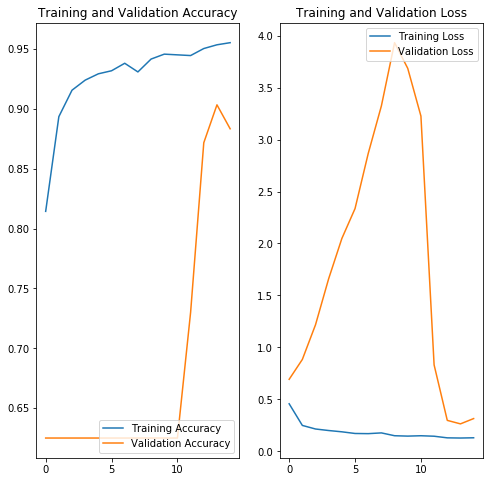

In [0]:
7# Visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [0]:
#Tranfer learning
img_dims = (IMG_HEIGHT, IMG_WIDTH, 3)

model_learn = Sequential()
model_learn.add(
    ResNet50(
        include_top=False, 
        pooling='avg', 
        weights='imagenet'
        )
    )
model_learn.add(
    Dense(1, activation='softmax')
)

# Say not to train first layer(ResNet) model. it is already trained
model_learn.layers[0].trainable = False

In [0]:
model_learn.compile(ptimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights_learn.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

In [0]:
model_learn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


In [0]:
history = model_learn.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=10,
    validation_data = val_data_gen,
    validation_steps=total_val // batch_size,
    callbacks=[lr_reduce]
)

Epoch 1/10
52/52 [==============================] - 707s 14s/step - loss: 3.9689 - accuracy: 0.7412 - val_loss: 5.4689 - val_accuracy: 0.6433
Epoch 2/10
52/52 [==============================] - 662s 13s/step - loss: 3.9370 - accuracy: 0.7444 - val_loss: 5.4689 - val_accuracy: 0.6433
Epoch 3/10
51/52 [============================>.] - ETA: 12s - loss: 3.9725 - accuracy: 0.7422
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
52/52 [==============================] - 677s 13s/step - loss: 3.9606 - accuracy: 0.7429 - val_loss: 5.4689 - val_accuracy: 0.6433
Epoch 4/10
52/52 [==============================] - 682s 13s/step - loss: 3.9631 - accuracy: 0.7415 - val_loss: 5.4689 - val_accuracy: 0.6433
Epoch 5/10
51/52 [============================>.] - ETA: 12s - loss: 3.9866 - accuracy: 0.7400
Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
52/52 [==============================] - 694s 13s/step - loss: 3.9866 - accuracy: 0.7400 - va